# 1. Data Import

In [2]:
#!pip install --user imblearn

     |████████████████████████████████| 174kB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 6.6MB 54.5MB/s eta 0:00:01


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import time
import pickle
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rstate=42

%matplotlib inline
sns.set(font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, psutil

#Check CPU Memory Usage 
def cpuStats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0] / 2. ** 30
    print('memory GB:', memoryUse)

In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }

keep_cols = ['ip','app','device','os','channel','click_time','is_attributed']
missing_values = ['n/a', 'na', '--', 'NA', 'NaN']
data = pd.read_csv('train.csv', usecols = keep_cols, dtype = dtypes, na_values = missing_values)

data.head()

,ip,app,device,os,channel,click_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,0
1,17357,3,1,19,379,2017-11-06 14:33:34,0
2,35810,3,1,13,379,2017-11-06 14:34:12,0
3,45745,14,1,13,478,2017-11-06 14:34:52,0
4,161007,3,1,13,379,2017-11-06 14:35:08,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 7 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed    uint8
dtypes: object(1), uint16(4), uint32(1), uint8(1)
memory usage: 3.6+ GB


In [9]:
data.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


In [8]:
cpuStats()
gc.collect()

memory GB: 5.327938079833984


# 2. Click_time Conversion

In [4]:
#Split out the clicktime
data.click_time = pd.to_datetime(data.click_time)
data['day'] = data['click_time'].dt.dayofweek.astype('uint8')
data['hour'] = data['click_time'].dt.hour.astype('uint8')
data['minute'] = data['click_time'].dt.minute.astype('uint8')
data['second'] = data['click_time'].dt.second.astype('uint8')

data.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,second
0,83230,3,1,13,379,2017-11-06 14:32:21,0,0,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,0,0,14,33,34
2,35810,3,1,13,379,2017-11-06 14:34:12,0,0,14,34,12
3,45745,14,1,13,478,2017-11-06 14:34:52,0,0,14,34,52
4,161007,3,1,13,379,2017-11-06 14:35:08,0,0,14,35,8


In [6]:
#data.to_feather('data_w_clicktime.feather')

# 3. EDA

In [11]:
# Set variables as categorical

variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    data[v] = data[v].astype('category')

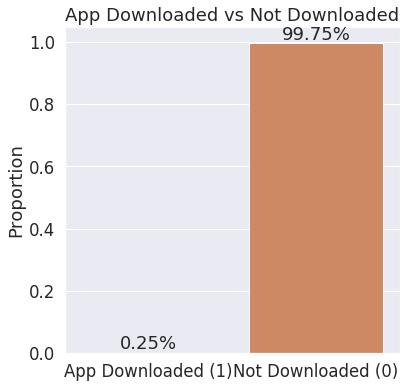

In [12]:
# Plot dataset balance

plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (data.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

Number of unique devices:  3475
Number of unique apps:  706
Number of unique os:  800
Number of unique ips:  277396
Number of unique channels:  202


Text(0.5, 0, 'Feature')

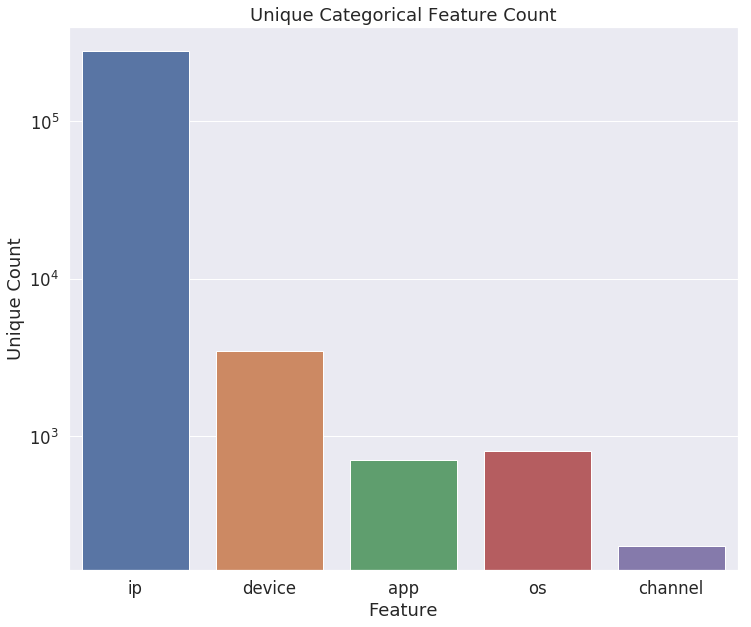

In [13]:
# Unique value for different cols

print('Number of unique devices: ', data.device.nunique())
print('Number of unique apps: ', data.app.nunique())
print('Number of unique os: ', data.os.nunique())
print('Number of unique ips: ', data.ip.nunique())
print('Number of unique channels: ', data.channel.nunique())

#Create a unique counts df
categorical_counts = pd.DataFrame(data.iloc[:,:5].nunique(), columns = ['Unique_Count'])

#plot the unique counts by column
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.barplot(x = categorical_counts.index ,y = 'Unique_Count', data = categorical_counts, order= ['ip', 'device', 'app', 'os', 'channel'])
plt.yscale('log')

plt.title('Unique Categorical Feature Count')
plt.ylabel('Unique Count')
plt.xlabel('Feature')

# Change scaling of unique count

## 3a. Conversion Rates

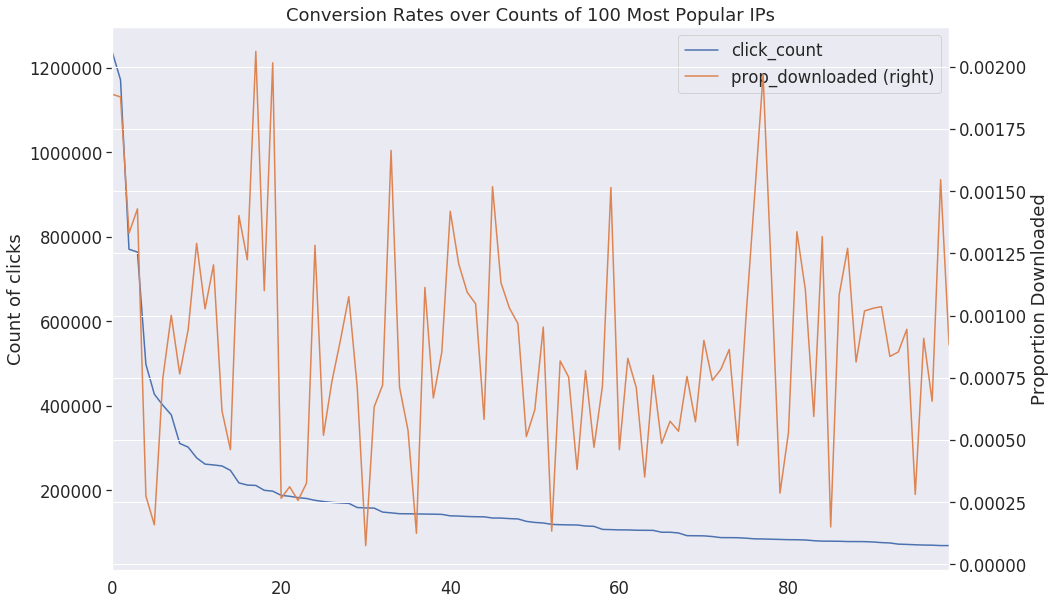

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0     5348      1238734         0.001889
1     5314      1171448         0.001878
2    73516       770451         0.001330
3    73487       763854         0.001428
4    53454       498186         0.000275
5   114276       427453         0.000159
6    26995       401495         0.000747
7    95766       378693         0.001001
8    17149       310996         0.000765
9   105475       302192         0.000943
10  100275       276799         0.001290
11   43793       261970         0.001027
12  105560       260049         0.001204
13   86767       257649         0.000617
14  111025       247187         0.000461
15  137052       217614         0.001402
16  201182       212448         0.001224
17    5178       211556         0.002061
18   49602       200053         0.001100
19    5147       197994         0.002015


In [14]:
# Plot conversion rates over counts for top 100 IPs

proportion = data[['ip', 'is_attributed']].groupby('ip').mean().sort_values('is_attributed', ascending=False)
counts = data[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

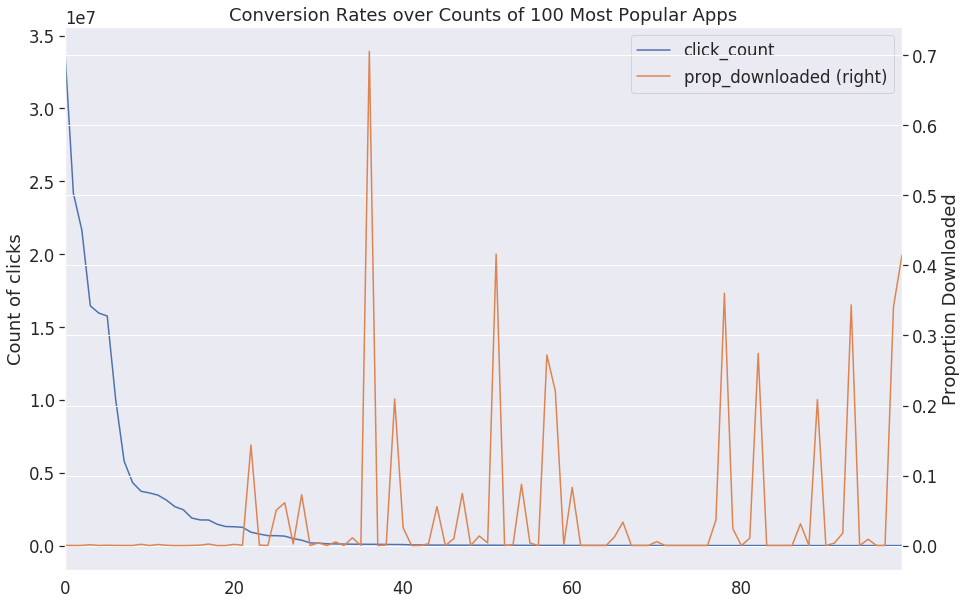

Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0    3     33911780         0.000303
1   12     24179003         0.000109
2    2     21642136         0.000262
3    9     16458268         0.001144
4   15     15958970         0.000214
5   18     15756587         0.000503
6   14     10027169         0.000250
7    1      5796274         0.000212
8   13      4329409         0.000167
9    8      3731948         0.001842
10  21      3616407         0.000133
11  11      3466971         0.001555
12  26      3126136         0.000467
13  23      2675259         0.000019
14   6      2464136         0.000083
15  64      1893969         0.000266
16   7      1764954         0.000670
17  20      1758934         0.002176
18  25      1467907         0.000047
19  28      1311496         0.000082


In [15]:
# Plot conversion rates over counts for top 100 Apps

proportion = data[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = data[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

del proportion
del counts
del merge
gc.collect()

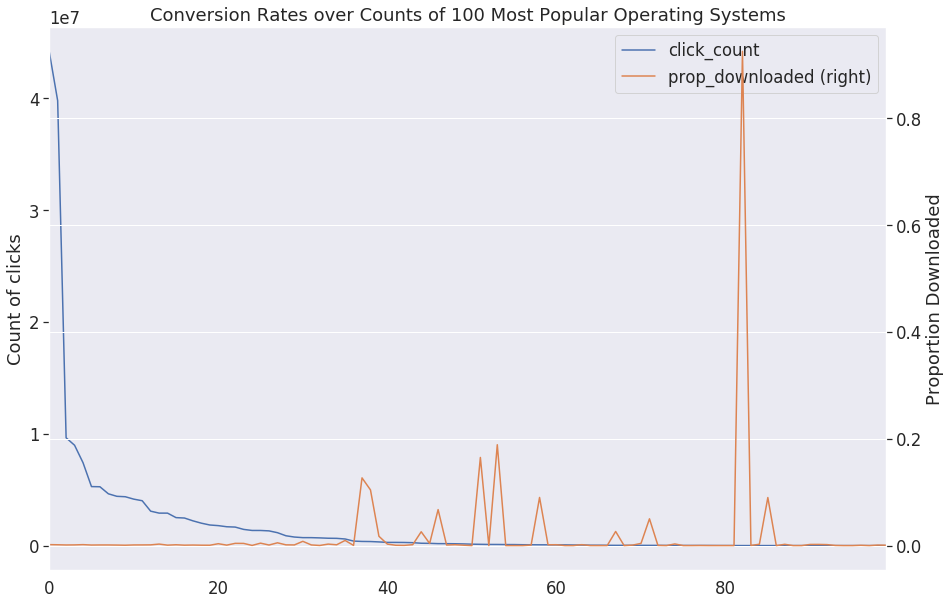

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19     44181914         0.001803
1   13     39782808         0.001549
2   17      9639776         0.001180
3   18      8974159         0.001302
4   22      7414405         0.001769
5    8      5278317         0.001063
6   10      5262422         0.001195
7    6      4632561         0.001184
8   15      4408470         0.000995
9    9      4370878         0.000730
10  25      4156096         0.001219
11  20      4013563         0.001257
12  16      3081268         0.001371
13  37      2905944         0.002832
14   3      2904808         0.000845
15  14      2503681         0.001545
16  41      2467180         0.000808
17   1      2215593         0.001035
18  12      2006410         0.000756
19  23      1844222         0.000681


10160

In [17]:
# Plot conversion rates over counts for top 100 OS

proportion = data[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = data[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)


merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

del proportion
del counts
del merge
gc.collect()

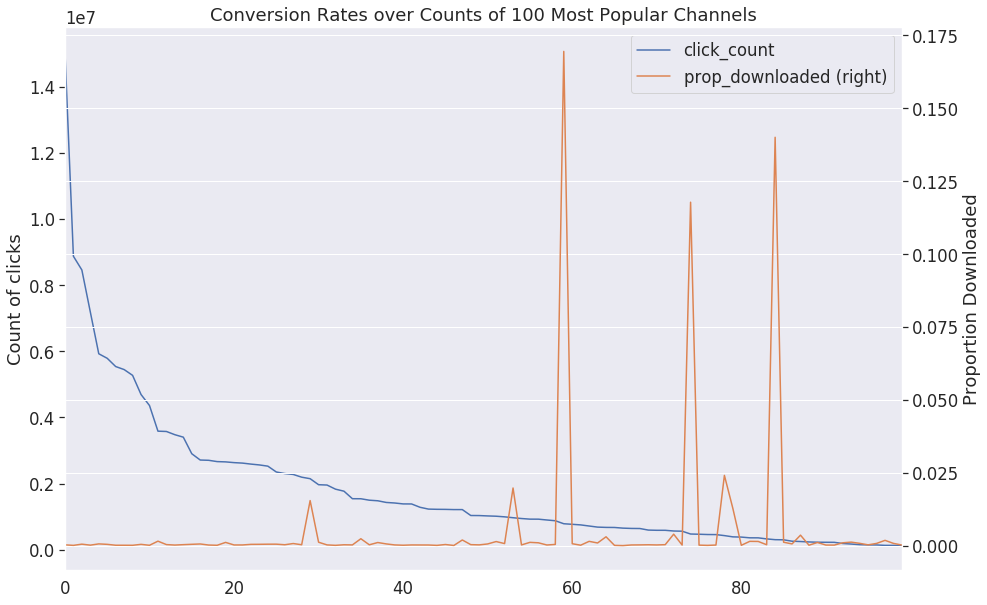

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      280     15065927         0.000270
1      245      8873025         0.000093
2      107      8457471         0.000504
3      477      7188340         0.000169
4      134      5924250         0.000595
5      259      5787004         0.000442
6      153      5537977         0.000138
7      265      5446388         0.000134
8      178      5271408         0.000119
9      121      4692438         0.000438
10     205      4359180         0.000120
11     145      3583945         0.001533
12     442      3574611         0.000358
13     459      3477150         0.000197
14     379      3402636         0.000335
15     439      2901762         0.000457
16     489      2711240         0.000569
17     128      2703163         0.000204
18     135      2663913         0.000125
19     466      2655396         0.001111


3753

In [18]:
# Plot Conversion rates over counts for top Channels

proportion = data[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = data[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Channels')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

del proportion
del counts
del merge
gc.collect()

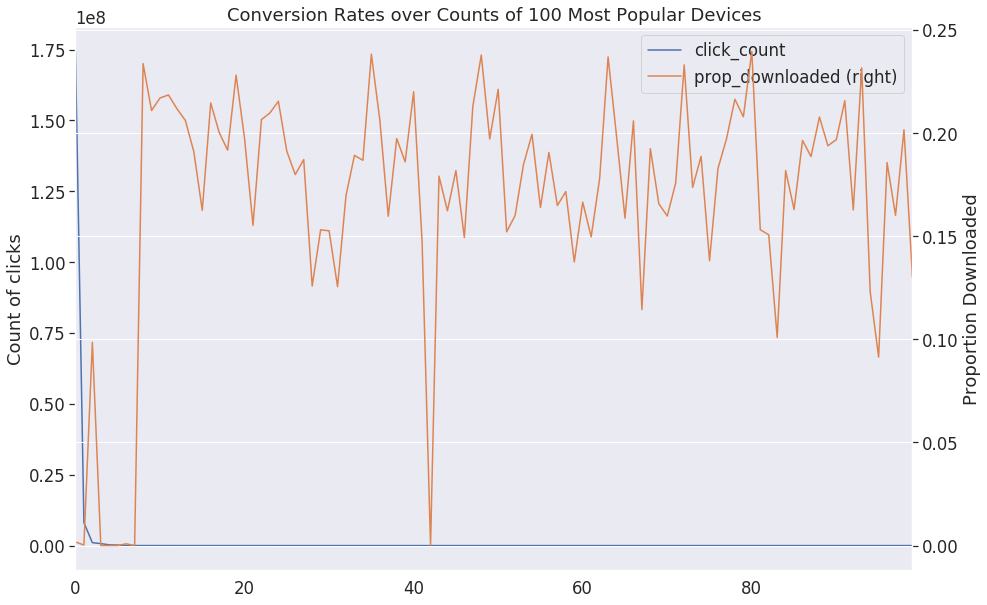

Counversion Rates over Counts of Most Popular Devices
   device  click_count  prop_downloaded
0       1    174330052         0.001758
1       2      8105054         0.000274
2       0      1033413         0.098525
3    3032       692891         0.000006
4    3543       266596         0.000011
5    3866       178274         0.000011
6      59        24018         0.000874
7       5        14379         0.000000
8       6        12569         0.233670
9      40        12351         0.210914
10     16        10147         0.217010
11     18         6742         0.218481
12     21         5430         0.211786
13     33         5337         0.206108
14     30         4199         0.190998
15    154         4011         0.162553
16     67         3770         0.214589
17    114         3585         0.200279
18     37         3474         0.191710
19     88         3262         0.228081


4136

In [19]:
# Plot conversion rates over counts for top 100 Dev

proportion = data[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = data[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Devices')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Devices')
print(merge[:20])

del proportion
del counts
del merge
gc.collect()



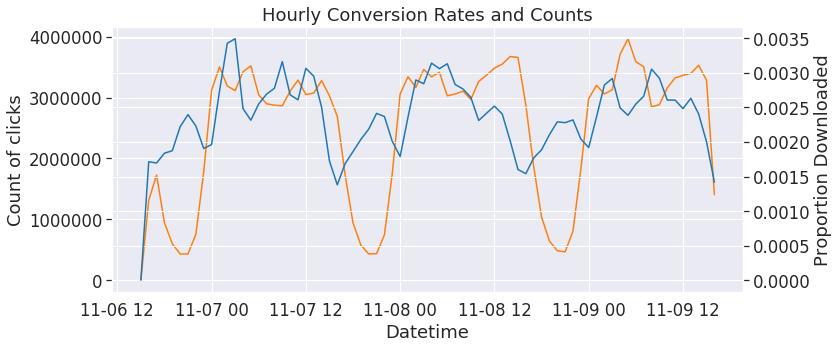

memory GB: 13.790668487548828


In [21]:
# Hourly conversion rates and counts

data['click_rnd']=data['click_time'].dt.round('H')  
clicks = data[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=False).count()
conversion_rate = data[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=False).mean()

fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:orange'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Count of clicks')
ax1.plot(clicks.click_rnd, clicks.is_attributed, color=color, label='clicks')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Proportion Downloaded')  # we already handled the x-label with ax1
ax2.plot(clicks.click_rnd, conversion_rate.is_attributed, color=color, label='conversion rate')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Hourly Conversion Rates and Counts')
plt.show()

del clicks
del conversion_rate
gc.collect()
cpuStats()

In [22]:
cpuStats()
gc.collect()

memory GB: 13.790668487548828


0

## 3b. Groupby EDA

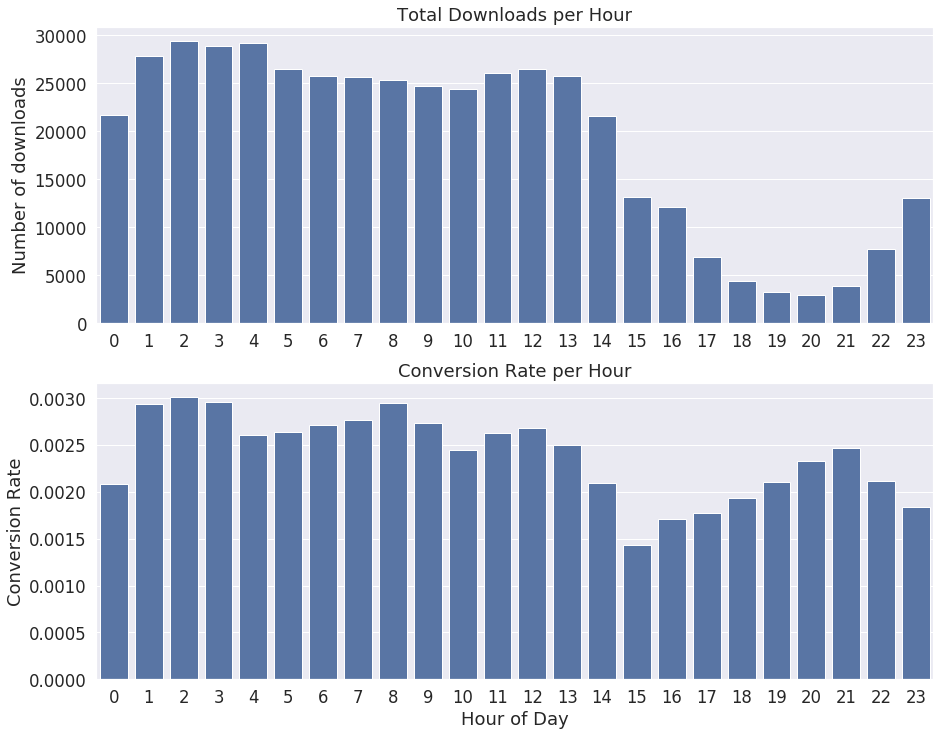

In [23]:
# Create grouped df hourly downloads and conversion rate (mean)

hour_summary = data.groupby('hour').agg({'is_attributed':['sum', 'mean']}).reset_index()
 
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'hour',''), y = ('is_attributed','sum'), color = 'b', data = hour_summary, ax = ax1)
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per Hour')

sns.barplot(x = ( 'hour',''), y = ('is_attributed','mean'), color = 'b', data = hour_summary, ax = ax2)
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('Hour of Day')
ax2.title.set_text('Conversion Rate per Hour')

del hour_summary

15000

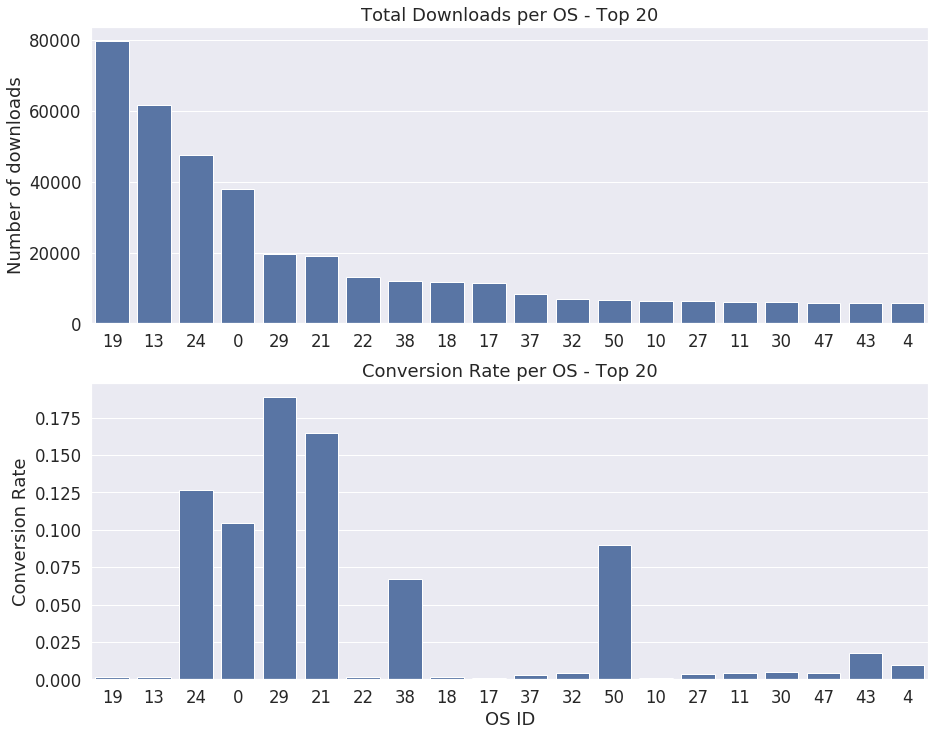

In [24]:
################################################### OS 
OS_summary = data.groupby('os').agg({'is_attributed':['sum', 'mean']}).reset_index()
OS_summary = OS_summary.sort_values(('is_attributed','sum'), ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'os',''), y = ('is_attributed','sum'), color = 'b', data = OS_summary[:20], ax = ax1, order = list(OS_summary.os[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per OS - Top 20')

sns.barplot(x = ( 'os',''), y = ('is_attributed','mean'), color = 'b', data = OS_summary[:20], ax = ax2, order = list(OS_summary.os[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('OS ID')
ax2.title.set_text('Conversion Rate per OS - Top 20')

del OS_summary
gc.collect()

9722

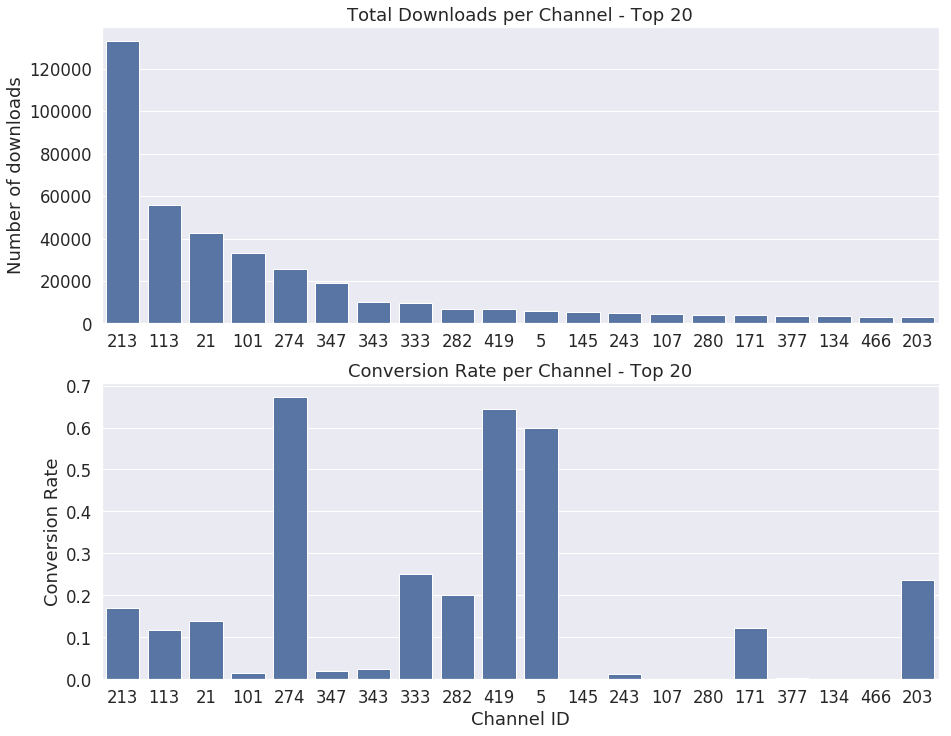

In [25]:
################################################## CHANNEL
channel_summary = data.groupby('channel').agg({'is_attributed':['sum', 'mean']}).reset_index()
channel_summary = channel_summary.sort_values(('is_attributed','sum'), ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'channel',''), y = ('is_attributed','sum'), color = 'b', data = channel_summary[:20], ax = ax1, order = list(channel_summary.channel[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per Channel - Top 20')

sns.barplot(x = ( 'channel',''), y = ('is_attributed','mean'), color = 'b', data = channel_summary[:20], ax = ax2, order = list(channel_summary.channel[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('Channel ID')
ax2.title.set_text('Conversion Rate per Channel - Top 20')

del channel_summary
gc.collect()

9864

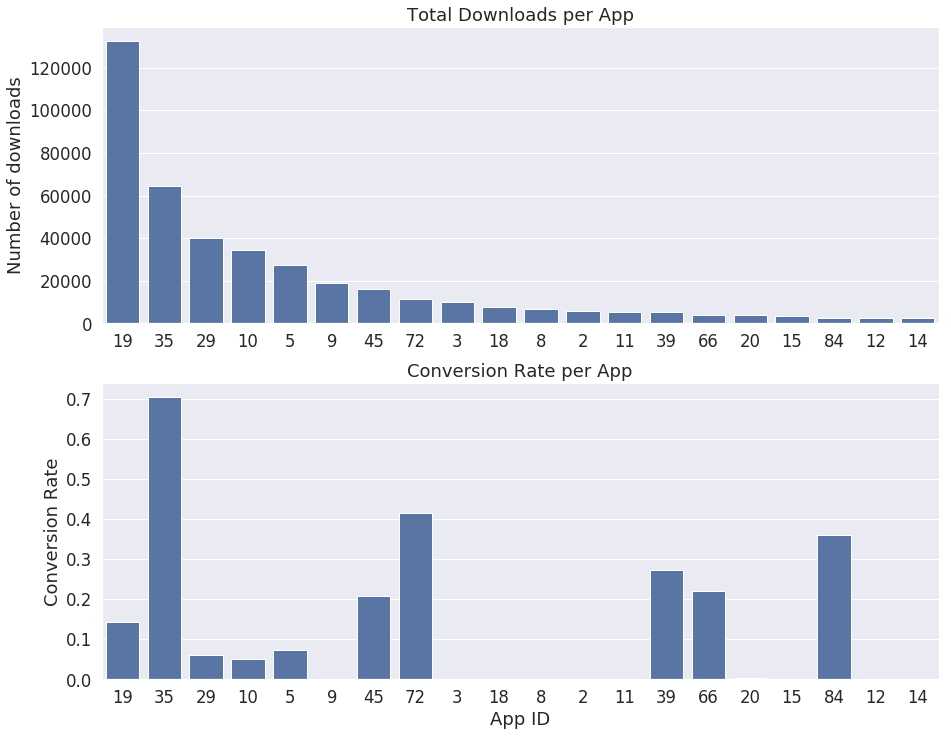

In [26]:
################################################## APP 
app_summary = data.groupby('app').agg({'is_attributed':['sum', 'mean']}).reset_index()
app_summary = app_summary.sort_values(('is_attributed','sum'), ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'app',''), y = ('is_attributed','sum'), color = 'b', data = app_summary[:20], ax = ax1, order = list(app_summary.app[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per App')

sns.barplot(x = ( 'app',''), y = ('is_attributed','mean'), color = 'b', data = app_summary[:20], ax = ax2, order = list(app_summary.app[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('App ID')
ax2.title.set_text('Conversion Rate per App')

del app_summary
gc.collect()

9881

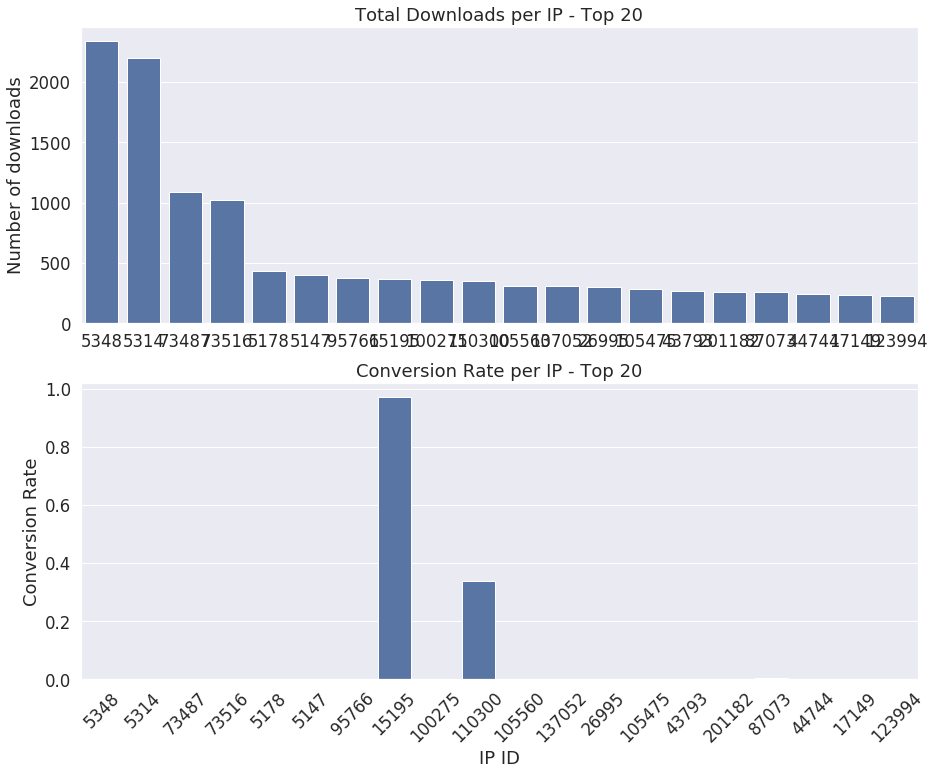

In [27]:
################################################### IP 
IP_summary = data.groupby('ip').agg({'is_attributed':['sum', 'mean']}).reset_index()
IP_summary = IP_summary.sort_values(('is_attributed','sum'), ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12))#, sharex='row')
plt.xticks(rotation=45)

sns.barplot(x = ( 'ip',''), y = ('is_attributed','sum'), color = 'b', data = IP_summary[:20], ax = ax1, order = list(IP_summary.ip[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per IP - Top 20')

sns.barplot(x = ( 'ip',''), y = ('is_attributed','mean'), color = 'b', data = IP_summary[:20], ax = ax2, order = list(IP_summary.ip[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('IP ID')
ax2.title.set_text('Conversion Rate per IP - Top 20')

del IP_summary
gc.collect()

9623

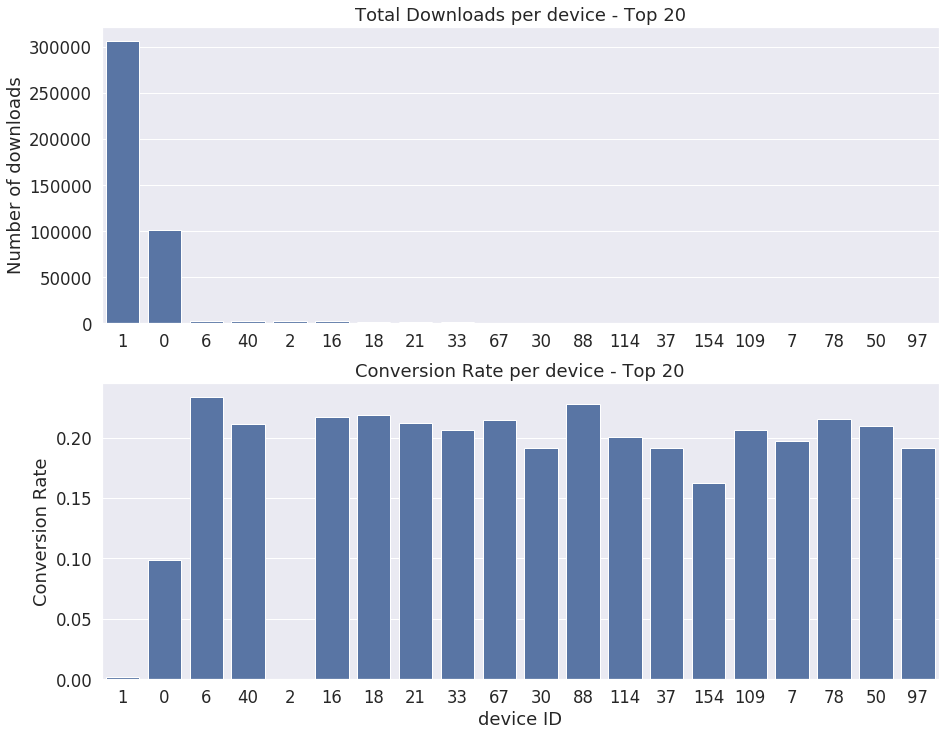

In [28]:
################################################### device 
device_summary = data.groupby('device').agg({'is_attributed':['sum', 'mean']}).reset_index()
device_summary = device_summary.sort_values(('is_attributed','sum'), ascending = False)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(15,12), sharex='row')

sns.barplot(x = ( 'device',''), y = ('is_attributed','sum'), color = 'b', data = device_summary[:20], ax = ax1, order = list(device_summary.device[:20].values))
ax1.set_ylabel('Number of downloads')
ax1.set_xlabel('')
ax1.title.set_text('Total Downloads per device - Top 20')

sns.barplot(x = ( 'device',''), y = ('is_attributed','mean'), color = 'b', data = device_summary[:20], ax = ax2, order = list(device_summary.device[:20].values))
ax2.set_ylabel('Conversion Rate')
ax2.set_xlabel('device ID')
ax2.title.set_text('Conversion Rate per device - Top 20')

del device_summary
gc.collect()

Text(0.5, 1.0, 'Percent Device Breakdown by ID \n')

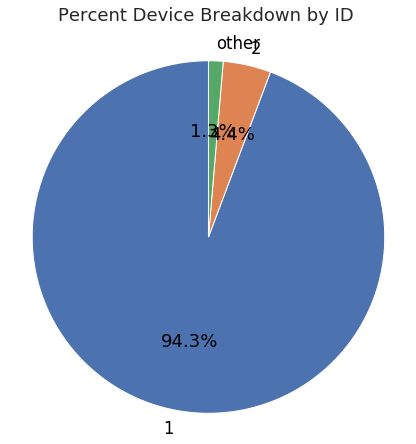

In [29]:
#Device representation
percent_device = data['device'].value_counts()/data.shape[0]
percent_device = pd.DataFrame(percent_device).reset_index()

percent_device.columns = ['Device', 'Percent']

#Create top 2 and other categories
percent_device_top2 = percent_device[:2].copy()

percent_device_other = pd.DataFrame({'Device':['other'], 'Percent': [percent_device['Percent'][2:].sum()]})

#Merge the dfs
percent_device_grouped = pd.concat([percent_device_top2, percent_device_other])

#Plot the piechart
fig1, ax1 = plt.subplots(figsize = (7,7))
patches, texts, autotexts = ax1.pie('Percent', labels='Device', autopct='%1.1f%%', startangle=90, data = percent_device_grouped)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title('Percent Device Breakdown by ID \n')

In [30]:
del percent_device
del percent_device_top2
del percent_device_other
del percent_device_grouped
gc.collect()
cpuStats()

memory GB: 13.796802520751953


# 4. Baseline Models

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['is_attributed','click_time'], axis=1), # took out the drop 'click_rnd'
                                                    data.is_attributed.values,
                                                    test_size=0.3, 
                                                    stratify=data.is_attributed.values, 
                                                   random_state = rstate)

print('X_train & test sizes:', np.shape(X_train), np.shape(X_test))
print('y_train & test sizes:', np.shape(y_train), np.shape(y_test))

X_train & test sizes: (129432723, 9) (55471167, 9)
y_train & test sizes: (129432723,) (55471167,)


In [32]:
X_train

,ip,app,device,os,channel,day,hour,minute,second
88023710,110207,17,1,15,280,2,5,41,24
52872449,84901,9,2,19,334,1,13,45,14
50975188,4136,11,1,13,219,1,13,9,49
60796081,207807,9,1,22,466,1,16,24,1
169127197,107968,12,1,13,205,3,11,15,22
...,...,...,...,...,...,...,...,...,...
83544672,49602,6,1,19,125,2,4,22,9
7411944,142650,14,1,22,379,0,23,14,27
119061441,99944,2,2,49,237,2,15,5,3
53795252,123974,9,1,8,489,1,14,1,47


In [33]:
# RandomForest Baseline

RF_mod = RandomForestClassifier(min_samples_leaf=100, verbose =1)
RF_mod.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 377.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [34]:
# save the model to disk
filename = 'RF_mod.sav'
pickle.dump(RF_mod, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [35]:
y_pred_tra_RFBL = RF_mod.predict(X_train)
y_pred_tst_RFBL = RF_mod.predict(X_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.5min finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.7min finished


In [36]:
print('Random Forest Baseline Classification Reports:\n\n')

print('Baseline RF X_train Prediction:\n', classification_report(y_train, y_pred_tra_RFBL))
print('Baseline RF X_test Prediction:\n', classification_report(y_test, y_pred_tst_RFBL))

Random Forest Baseline Classification Reports:


Baseline RF X_train Prediction:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00 129112931
          1       0.82      0.33      0.47    319792

avg / total       1.00      1.00      1.00 129432723

Baseline RF X_test Prediction:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00  55334113
          1       0.81      0.33      0.47    137054

avg / total       1.00      1.00      1.00  55471167



In [37]:
print('Random Forest Baseline ROC_AUC Reports:\n\n')

print('Baseline RF X_train Prediction:\n', roc_auc_score(y_train, y_pred_tra_RFBL))
print('Baseline RF X_test Prediction:\n', roc_auc_score(y_test, y_pred_tst_RFBL))

Random Forest Baseline ROC_AUC Reports:


Baseline RF X_train Prediction:
 0.6665695015675492
Baseline RF X_test Prediction:
 0.6655235617319419


In [10]:
X_train

,ip,app,device,os,channel,day,hour,minute,second
81736010,285581,12,2,20,265,2,3,50,26
183846649,104764,18,1,14,107,3,15,36,55
111200692,158099,18,1,16,439,2,12,55,53
68261758,75504,12,1,25,219,1,23,44,51
112174090,282175,8,1,13,145,2,13,12,1
...,...,...,...,...,...,...,...,...,...
91730531,82240,3,1,13,130,2,6,55,32
25072904,14966,18,1,25,134,1,4,41,59
52290932,83420,3,1,13,480,1,13,34,39
45007560,5348,3,1,9,280,1,11,12,28


In [15]:
pd.concat([X_train.reset_index(), pd.Series(y_train)], axis=1).rename(columns = {0:'is_attributed'}).to_feather('X_train_y_train.feather')
pd.concat([X_test.reset_index(), pd.Series(y_test)], axis=1).rename(columns = {0:'is_attributed'}).to_feather('X_test_y_test.feather')

In [16]:
cpuStats()
gc.collect()

memory GB: 33.629459381103516


1333

In [4]:
# X_train = pd.read_feather('X_train_y_train.feather', columns = ['ip','app','device','os','channel','day','hour','minute','second'])
# X_test = pd.read_feather('X_test_y_test.feather', columns = ['ip','app','device','os','channel','day','hour','minute','second'])

# y_train = pd.read_feather('X_train_y_train.feather', columns = ['is_attributed']).values.ravel()
# y_test = pd.read_feather('X_test_y_test.feather', columns = ['is_attributed']).values.ravel()

In [13]:
cpuStats()
gc.collect()

memory GB: 3.1738739013671875


0

In [15]:
# Logistic Regression Baseline Model

LR_mod = LogisticRegression(random_state = rstate)
LR_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# save the model to disk
filename = 'LR_mod.sav'
pickle.dump(LR_mod, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

In [17]:
y_pred_tra_LRBL = LR_mod.predict(X_train)
y_pred_tst_LRBL = LR_mod.predict(X_test)

In [18]:
print('Logistic Regression Baseline Classification Reports:\n\n')

print('Baseline LR X_train Prediction:\n', classification_report(y_train, y_pred_tra_LRBL))
print('Baseline LR X_test Prediction:\n', classification_report(y_test, y_pred_tst_LRBL))

Logistic Regression Baseline Classification Reports:


Baseline LR X_train Prediction:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00 129112931
           1       0.09      0.00      0.00    319792

    accuracy                           1.00 129432723
   macro avg       0.55      0.50      0.50 129432723
weighted avg       1.00      1.00      1.00 129432723

Baseline LR X_test Prediction:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00  55334113
           1       0.11      0.00      0.00    137054

    accuracy                           1.00  55471167
   macro avg       0.56      0.50      0.50  55471167
weighted avg       1.00      1.00      1.00  55471167



In [19]:
print('Logistic Regression Baseline ROC_AUC Reports:\n\n')

print('Baseline LR X_train Prediction:\n', roc_auc_score(y_train, y_pred_tra_LRBL))
print('Baseline LR X_test Prediction:\n', roc_auc_score(y_test, y_pred_tst_LRBL))

Logistic Regression Baseline ROC_AUC Reports:


Baseline LR X_train Prediction:
 0.5007386608117844
Baseline LR X_test Prediction:
 0.5009016531375848


In [21]:
del X_train
del X_test
del y_train
del y_test
gc.collect()

0

In [22]:
cpuStats()
gc.collect()

memory GB: 25.223079681396484


0

# 5. Random Undersampling

In [7]:
cpuStats()
gc.collect()

memory GB: 4.499927520751953


0

In [4]:
data = pd.read_feather('data_w_clicktime.feather')

In [8]:
# Class count | 0 = no download 1 = download
count_class_0, count_class_1 = data.is_attributed.value_counts()

# Divide by class 
data_0 = data[data['is_attributed'] == 0]
data_is_attributed = data[data['is_attributed'] == 1]

#Use the DataFrame.sample to randomly sample the number of downloads from the non-downloads (data_0)
df_class_0_under = data_0.sample(count_class_1, replace = False, random_state=rstate)

#Concatenate the rows of data_0 & data_is_attributed
data_res = pd.concat([df_class_0_under, data_is_attributed], axis=0)

In [22]:
cpuStats()
gc.collect()

memory GB: 11.659492492675781


2657

In [17]:
data_res.reset_index().to_feather('data_res.feather')

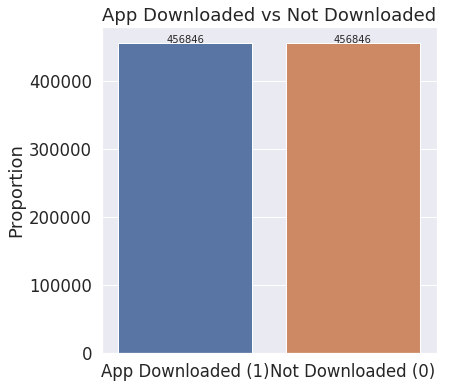

In [13]:
# Plot dataset balance

plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
summ = (data_res.is_attributed.values == 1).sum()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [summ, len(data_res)-summ])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [summ, len(data_res)-summ]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}'.format(uniq),
            ha="center")


In [20]:
data_res.head()

,ip,app,device,os,channel,click_time,is_attributed,day,hour,minute,second
46608628,31012,2,1,18,219,2017-11-07 11:43:36,0,1,11,43,36
153478577,58404,2,1,19,477,2017-11-09 06:17:46,0,3,6,17,46
97459643,105560,12,1,19,328,2017-11-08 08:47:20,0,2,8,47,20
122871484,50301,12,1,23,340,2017-11-08 16:16:04,0,2,16,16,4
113711899,77840,18,1,46,439,2017-11-08 13:37:37,0,2,13,37,37


In [24]:
# usam = RandomUnderSampler(random_state=rstate)
# X_res, y_res = usam.fit_resample(data.drop('is_attributed', axis=1), data.is_attributed.values)

# X_res = pd.DataFrame(X_res)
# X_res.columns = data.drop('is_attributed', axis=1).columns
# X_res

X_res = data_res.drop(['is_attributed'], axis = 1).copy()
y_res = data_res.is_attributed.copy()

In [25]:
print('X_res shape:', np.shape(X_res))
print('y_res shape:', np.shape(y_res))

X_res shape: (913692, 10)
y_res shape: (913692,)


In [30]:
y_res = pd.DataFrame(y_res)
y_res

,is_attributed
46608628,0
153478577,0
97459643,0
122871484,0
113711899,0
...,...
184872662,1
184872697,1
184876854,1
184877082,1


In [28]:
#SAVING TO FEATHER
X_res.reset_index().to_feather('X_res.feather')
y_res.reset_index().to_feather('y_res.feather')

In [42]:
X_train_DS, X_test_DS, y_train_DS, y_test_DS = train_test_split(X_res.drop(['click_time'], axis=1), #X_res.drop(['click_time','click_rnd'], axis=1),
                                                                y_res.values.ravel(),
                                                                test_size=0.3, 
                                                                stratify=y_res.values.ravel(), ### ADDED .ravel()
                                                               random_state = rstate) #### ADDED RANDOM STATE

print('X_train & test sizes:', np.shape(X_train_DS), np.shape(X_test_DS))
print('y_train & test sizes:', np.shape(y_train_DS), np.shape(y_test_DS))

X_train & test sizes: (639584, 9) (274108, 9)
y_train & test sizes: (639584,) (274108,)


In [45]:
# RandomForest Baseline
RF_mod_DS = RandomForestClassifier(random_state=rstate)
RF_mod_DS.fit(X_train_DS, y_train_DS)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [46]:
y_pred_tra_RFDS = RF_mod_DS.predict(X_train_DS)
y_pred_tst_RFDS = RF_mod_DS.predict(X_test_DS)

In [47]:
print('Random Forest Downsampled Classification Reports:\n\n')

print('Downsampled RF X_train Prediction:\n', classification_report(y_train_DS, y_pred_tra_RFDS))
print('Downsampled RF X_test Prediction:\n', classification_report(y_test_DS, y_pred_tst_RFDS))

Random Forest Downsampled Classification Reports:


Downsampled RF X_train Prediction:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    319792
           1       1.00      0.98      0.99    319792

    accuracy                           0.99    639584
   macro avg       0.99      0.99      0.99    639584
weighted avg       0.99      0.99      0.99    639584

Downsampled RF X_test Prediction:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92    137054
           1       0.95      0.88      0.91    137054

    accuracy                           0.92    274108
   macro avg       0.92      0.92      0.92    274108
weighted avg       0.92      0.92      0.92    274108



In [48]:
print('Random Forest Downsampled ROC_AUC Reports:\n\n')

print('Downsampled RF X_train Prediction:\n', roc_auc_score(y_train_DS, y_pred_tra_RFDS))
print('Downsampled RF X_test Prediction:\n', roc_auc_score(y_test_DS, y_pred_tst_RFDS))

Random Forest Downsampled ROC_AUC Reports:


Downsampled RF X_train Prediction:
 0.9911958397958672
Downsampled RF X_test Prediction:
 0.9160258000496154


In [49]:
# Logistic Regression Baseline Model

LR_mod_DS = LogisticRegression(random_state=rstate)
LR_mod_DS.fit(X_train_DS, y_train_DS)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_pred_tra_LRDS = LR_mod_DS.predict(X_train_DS)
y_pred_tst_LRDS = LR_mod_DS.predict(X_test_DS)

In [51]:
print('Logistic Regression Downsampled Classification Reports:\n\n')

print('Downsampled LR X_train Prediction:\n', classification_report(y_train_DS, y_pred_tra_LRDS))
print('Downsampled LR X_test Prediction:\n', classification_report(y_test_DS, y_pred_tst_LRDS))

Logistic Regression Downsampled Classification Reports:


Downsampled LR X_train Prediction:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76    319792
           1       0.76      0.75      0.76    319792

    accuracy                           0.76    639584
   macro avg       0.76      0.76      0.76    639584
weighted avg       0.76      0.76      0.76    639584

Downsampled LR X_test Prediction:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76    137054
           1       0.76      0.75      0.76    137054

    accuracy                           0.76    274108
   macro avg       0.76      0.76      0.76    274108
weighted avg       0.76      0.76      0.76    274108



In [52]:
print('Logistic Regression Downsampled ROC_AUC Reports:\n\n')

print('Downsampled LR X_train Prediction:\n', roc_auc_score(y_train_DS, y_pred_tra_LRDS))
print('Downsampled LR X_test Prediction:\n', roc_auc_score(y_test_DS, y_pred_tst_LRDS))

Logistic Regression Downsampled ROC_AUC Reports:


Downsampled LR X_train Prediction:
 0.7566042927903137
Downsampled LR X_test Prediction:
 0.7568111839129104


In [53]:
del X_train_DS
del X_test_DS
del y_train_DS
del y_test_DS

cpuStats()
gc.collect()

memory GB: 11.87990951538086


<function gc.collect>

# 6. Feature Engineering

## 6a. Combination Counts

In [54]:
# Feature Engineering

# Build the double combos
cols = X_res.columns[:5]
for i in np.arange(0,4):
    for j in np.arange(i+1,5):
            X_res[str(cols[i]+'_'+cols[j])] = X_res[cols[i]].map(str)+'_'+X_res[cols[j]].map(str)
            
# Build the double combo counts
for col in X_res.columns[-10:]:
    X_res = X_res.join(X_res[col].value_counts(), on=col, how='left', rsuffix='_counts')

# Drop the combo columns now that we have the counts
cols_drop = X_res.columns[-20:-10].values
X_res = X_res.drop(cols_drop, axis=1)

# Build the triple combination columns
cols = X_res.columns[:5]
for i in np.arange(0,3):
    for j in np.arange(i+1,4):
        for k in np.arange(j+1,5):
            X_res[str(cols[i]+'_'+cols[j]+'_'+cols[k])] = (
                    X_res[cols[i]].map(str)+'_'+X_res[cols[j]].map(str)+'_'+X_res[cols[k]].map(str))
            
# Build the triple combo counts
for col in X_res.columns[-10:]:
    X_res = X_res.join(X_res[col].value_counts(), on=col, how='left', rsuffix='_counts')
    
# Drop the combo columns now that we have the counts
cols_drop = X_res.columns[-20:-10].values
X_res = X_res.drop(cols_drop, axis=1)

# Build the quadruple combos
for i in np.arange(0,2):
    for j in np.arange(i+1,3):
        for k in np.arange(j+1,4):
            for l in np.arange(k+1,5):
                X_res[str(cols[i]+'_'+cols[j]+'_'+cols[k]+'_'+cols[l])] = (
                    X_res[cols[i]].map(str)+'_'+X_res[cols[j]].map(str)+'_'+X_res[cols[k]].map(str)+'_'+X_res[cols[l]].map(str))

# Build the 5-combo column:
X_res[str(cols[0]+'_'+cols[1]+'_'+cols[2]+'_'+cols[3]+'_'+cols[4])] = (
                    X_res[cols[0]].map(str)+'_'+X_res[cols[1]].map(str)+'_'+X_res[cols[2]].map(str)+'_'+X_res[cols[3]].map(str)+'_'+X_res[cols[4]].map(str))

# Build the quadruple and 5-combo counts
for col in X_res.columns[-6:]:
    X_res = X_res.join(X_res[col].value_counts(), on=col, how='left', rsuffix='_counts')
    
# Drop the combo columns now that we have the counts
cols_drop = X_res.columns[-12:-6].values
X_res = X_res.drop(cols_drop, axis=1)

In [55]:
X_res.head()

,ip,app,device,os,channel,click_time,day,hour,minute,second,...,app_device_os_counts,app_device_channel_counts,app_os_channel_counts,device_os_channel_counts,ip_app_device_os_counts,ip_app_device_channel_counts,ip_app_os_channel_counts,ip_device_os_channel_counts,app_device_os_channel_counts,ip_app_device_os_channel_counts
46608628,31012,2,1,18,219,2017-11-07 11:43:36,1,11,43,36,...,2610,4873,213,295,1,2,1,1,211,1
153478577,58404,2,1,19,477,2017-11-09 06:17:46,3,6,17,46,...,14751,9390,2176,4690,2,2,1,1,2133,1
97459643,105560,12,1,19,328,2017-11-08 08:47:20,2,8,47,20,...,14879,4666,1199,1194,24,9,2,2,1194,2
122871484,50301,12,1,23,340,2017-11-08 16:16:04,2,16,16,4,...,986,1599,138,138,1,1,1,1,138,1
113711899,77840,18,1,46,439,2017-11-08 13:37:37,2,13,37,37,...,88,5727,4,6,1,1,1,1,4,1


In [56]:
scaler = StandardScaler()
X_res.iloc[:,-26:] = scaler.fit_transform(X_res.iloc[:,-26:])

In [57]:
X_res

,ip,app,device,os,channel,click_time,day,hour,minute,second,...,app_device_os_counts,app_device_channel_counts,app_os_channel_counts,device_os_channel_counts,ip_app_device_os_counts,ip_app_device_channel_counts,ip_app_os_channel_counts,ip_device_os_channel_counts,app_device_os_channel_counts,ip_app_device_os_channel_counts
46608628,31012,2,1,18,219,2017-11-07 11:43:36,1,11,43,36,...,-0.508225,-0.536898,-0.495379,-0.627657,-0.124508,-0.103110,-0.110492,-0.119514,-0.515742,-0.103095
153478577,58404,2,1,19,477,2017-11-09 06:17:46,3,6,17,46,...,0.925856,-0.280078,-0.217581,0.292832,-0.033828,-0.103110,-0.110492,-0.119514,-0.072739,-0.103095
97459643,105560,12,1,19,328,2017-11-08 08:47:20,2,8,47,20,...,0.940975,-0.548667,-0.355843,-0.439370,1.961139,0.222183,0.075324,0.063148,-0.289170,0.097660
122871484,50301,12,1,23,340,2017-11-08 16:16:04,2,16,16,4,...,-0.700050,-0.723046,-0.505992,-0.660539,-0.124508,-0.149580,-0.110492,-0.119514,-0.532568,-0.103095
113711899,77840,18,1,46,439,2017-11-08 13:37:37,2,13,37,37,...,-0.806121,-0.488343,-0.524956,-0.688185,-0.124508,-0.149580,-0.110492,-0.119514,-0.563454,-0.103095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184872662,313982,10,1,27,113,2017-11-09 15:59:21,3,15,59,21,...,-0.540117,0.846134,-0.198760,0.256389,-0.124508,-0.149580,-0.110492,-0.119514,-0.032172,-0.103095
184872697,331467,5,1,47,113,2017-11-09 15:59:21,3,15,59,21,...,-0.549094,0.713716,-0.206402,0.271888,-0.124508,-0.149580,-0.110492,-0.119514,-0.044619,-0.103095
184876854,29789,45,1,32,419,2017-11-09 15:59:26,3,15,59,26,...,-0.718359,-0.434158,-0.444433,-0.569432,-0.124508,-0.103110,-0.110492,-0.119514,-0.432305,-0.103095
184877082,308776,10,1,11,113,2017-11-09 15:59:26,3,15,59,26,...,-0.531849,0.846134,-0.186448,0.291994,-0.124508,-0.149580,-0.110492,-0.119514,-0.012120,-0.103095


## 6b. Time to Next Click

In [58]:
# Build the double combos
cols = X_res.columns[:5]
for i in np.arange(0,4):
    for j in np.arange(i+1,5):
            X_res[str(cols[i]+'_'+cols[j]+'_nextClick')] = (
                X_res.groupby([cols[i], cols[j]]).click_time.shift(-1) - X_res.click_time).dt.seconds.astype(np.float32)

In [59]:
# Build the triple combination columns
cols = X_res.columns[:5]
for i in np.arange(0,3):
    for j in np.arange(i+1,4):
        for k in np.arange(j+1,5):
            X_res[str(cols[i]+'_'+cols[j]+'_'+cols[k]+'_nextClick')] = (
                    X_res.groupby([cols[i], cols[j], cols[k]]).click_time.shift(-1) - X_res.click_time).dt.seconds.astype(np.float32)

In [60]:
# Build the quadruple combos
for i in np.arange(0,2):
    for j in np.arange(i+1,3):
        for k in np.arange(j+1,4):
            for l in np.arange(k+1,5):
                X_res[str(cols[i]+'_'+cols[j]+'_'+cols[k]+'_'+cols[l]+'_nextClick')] = (
                    X_res.groupby([cols[i], cols[j], cols[k], cols[l]]).click_time.shift(-1) - X_res.click_time).dt.seconds.astype(np.float32)

In [61]:
# Build the 5-combo column:
X_res[str(cols[0]+'_'+cols[1]+'_'+cols[2]+'_'+cols[3]+'_'+cols[4]+'_nextClick')] = (
    X_res.groupby([cols[0], cols[1], cols[2], cols[3], cols[4]]).click_time.shift(-1) - X_res.click_time).dt.seconds.astype(np.float32)

In [62]:
#Fill NAs with large value 1e10
X_res = X_res.fillna(1e10)

In [63]:
X_res

,ip,app,device,os,channel,click_time,day,hour,minute,second,...,app_device_os_nextClick,app_device_channel_nextClick,app_os_channel_nextClick,device_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_app_os_channel_nextClick,ip_device_os_channel_nextClick,app_device_os_channel_nextClick,ip_app_device_os_channel_nextClick
46608628,31012,2,1,18,219,2017-11-07 11:43:36,1,11,43,36,...,8.079100e+04,5.773700e+04,7.340600e+04,7.340600e+04,1.000000e+10,1.264200e+04,1.000000e+10,1.000000e+10,7.340600e+04,1.000000e+10
153478577,58404,2,1,19,477,2017-11-09 06:17:46,3,6,17,46,...,6.735000e+04,2.894000e+04,3.808300e+04,3.808300e+04,5.785000e+04,6.353700e+04,1.000000e+10,1.000000e+10,3.808300e+04,1.000000e+10
97459643,105560,12,1,19,328,2017-11-08 08:47:20,2,8,47,20,...,5.570400e+04,7.704000e+04,6.315100e+04,6.315100e+04,7.627600e+04,9.456000e+03,9.456000e+03,9.456000e+03,6.315100e+04,9.456000e+03
122871484,50301,12,1,23,340,2017-11-08 16:16:04,2,16,16,4,...,6.142600e+04,6.456600e+04,6.021500e+04,6.021500e+04,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,6.021500e+04,1.000000e+10
113711899,77840,18,1,46,439,2017-11-08 13:37:37,2,13,37,37,...,7.288700e+04,3.142800e+04,5.890700e+04,5.890700e+04,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,5.890700e+04,1.000000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184872662,313982,10,1,27,113,2017-11-09 15:59:21,3,15,59,21,...,1.000000e+10,5.000000e+00,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
184872697,331467,5,1,47,113,2017-11-09 15:59:21,3,15,59,21,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
184876854,29789,45,1,32,419,2017-11-09 15:59:26,3,15,59,26,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10
184877082,308776,10,1,11,113,2017-11-09 15:59:26,3,15,59,26,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


## 6c. Cyclical Time Conversion

In [67]:
#RECREATING THE CLICK_RND 
X_res['click_rnd'] = X_res['click_time'].dt.round('H')  

# Creating click_hour variable
X_res['click_hour'] = X_res.click_rnd.dt.hour
X_res['click_day'] = X_res.click_rnd.dt.day

# Dropping click_time and click_rnd
X_res= X_res.drop(['click_time','click_rnd'], axis=1)

In [68]:
# Cyclical by hour

hours_in_day = 24

X_res['sin_click_hour'] = np.sin(2*np.pi*X_res.click_hour/hours_in_day)
X_res['cos_click_hour'] = np.cos(2*np.pi*X_res.click_hour/hours_in_day)

X_res= X_res.drop(['click_hour'], axis=1)

X_res.head()

,ip,app,device,os,channel,day,hour,minute,second,ip_app_counts,...,device_os_channel_nextClick,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_app_os_channel_nextClick,ip_device_os_channel_nextClick,app_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,click_day,sin_click_hour,cos_click_hour
46608628,31012,2,1,18,219,1,11,43,36,-0.136522,...,73406.0,1.000000e+10,1.264200e+04,1.000000e+10,1.000000e+10,73406.0,1.000000e+10,7,1.224647e-16,-1.000000e+00
153478577,58404,2,1,19,477,3,6,17,46,-0.119743,...,38083.0,5.785000e+04,6.353700e+04,1.000000e+10,1.000000e+10,38083.0,1.000000e+10,9,1.000000e+00,6.123234e-17
97459643,105560,12,1,19,328,2,8,47,20,1.491040,...,63151.0,7.627600e+04,9.456000e+03,9.456000e+03,9.456000e+03,63151.0,9.456000e+03,8,7.071068e-01,-7.071068e-01
122871484,50301,12,1,23,340,2,16,16,4,-0.170080,...,60215.0,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,60215.0,1.000000e+10,8,-8.660254e-01,-5.000000e-01
113711899,77840,18,1,46,439,2,13,37,37,-0.153301,...,58907.0,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,58907.0,1.000000e+10,8,-5.000000e-01,-8.660254e-01


In [69]:
# Cyclical by day

days_in_week = 7

X_res['sin_click_day'] = np.sin(2*np.pi*X_res.click_day/days_in_week)
X_res['cos_click_day'] = np.cos(2*np.pi*X_res.click_day/days_in_week)

X_res = X_res.drop(['click_day'], axis=1)

X_res.head()

,ip,app,device,os,channel,day,hour,minute,second,ip_app_counts,...,ip_app_device_os_nextClick,ip_app_device_channel_nextClick,ip_app_os_channel_nextClick,ip_device_os_channel_nextClick,app_device_os_channel_nextClick,ip_app_device_os_channel_nextClick,sin_click_hour,cos_click_hour,sin_click_day,cos_click_day
46608628,31012,2,1,18,219,1,11,43,36,-0.136522,...,1.000000e+10,1.264200e+04,1.000000e+10,1.000000e+10,73406.0,1.000000e+10,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000
153478577,58404,2,1,19,477,3,6,17,46,-0.119743,...,5.785000e+04,6.353700e+04,1.000000e+10,1.000000e+10,38083.0,1.000000e+10,1.000000e+00,6.123234e-17,9.749279e-01,-0.222521
97459643,105560,12,1,19,328,2,8,47,20,1.491040,...,7.627600e+04,9.456000e+03,9.456000e+03,9.456000e+03,63151.0,9.456000e+03,7.071068e-01,-7.071068e-01,7.818315e-01,0.623490
122871484,50301,12,1,23,340,2,16,16,4,-0.170080,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,60215.0,1.000000e+10,-8.660254e-01,-5.000000e-01,7.818315e-01,0.623490
113711899,77840,18,1,46,439,2,13,37,37,-0.153301,...,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,58907.0,1.000000e+10,-5.000000e-01,-8.660254e-01,7.818315e-01,0.623490


In [70]:
del hours_in_day, days_in_week

In [ ]:
X_res

# 7. Pickle data for local file usage and modeling

In [72]:
train = pd.concat([X_res, y_res], axis=1)
train = train.rename(columns = {0:'is_attributed'})

In [73]:
with open('train_data.pkl', 'wb') as f:
    pickle.dump(train, f)